<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 2079, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 2079 (delta 108), reused 90 (delta 47), pack-reused 1920 (from 2)
Receiving objects: 100% (2079/2079), 20.35 MiB | 7.67 MiB/s, done.
Resolving deltas: 100% (1422/1422), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import gc

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage2
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results_stage_2

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.10% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
5.17% complete (down: 58497.5 kB/s up: 1671.3 kB/s peers: 10) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[

## Model

In [6]:
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
model_stage_1 = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model_stage_1.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [7]:
model = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)

## Load data

In [ ]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2, mode="tumor", model_stage_1=model_stage_1, device=device)
print(len(full_train_dataset), len(val_dataset))

In [ ]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

def visualize_from_loader(image_tensor, label_tensor, liver_mask):
    """
    Hiển thị 3 ảnh: Volume, Liver Mask, và Liver Mask + Segmentation

    Args:
        image_tensor: Tensor, shape [1, 1, D, H, W]
        label_tensor: Tensor, shape [1, 1, D, H, W]
        liver_mask: Tensor, shape [1, 1, D, H, W]
    Notes:
        - Chuyển đổi sang numpy
        - Hiển thị 3 ảnh: volume, liver mask, và liver mask + segmentation
    """

    # Chuyển đổi sang numpy, nén tensor về dạng [D, H, W]
    image = image_tensor.detach().cpu().numpy().squeeze()
    label = label_tensor.detach().cpu().numpy().squeeze()
    liver_mask = liver_mask.detach().cpu().numpy().squeeze()


    # Chọn độ sâu (ví dụ: độ sâu 40% của chiều sâu ảnh)
    depth = image.shape[0] // 2

    # Bảng màu cho mask khối u
    cmap1 = mcolors.ListedColormap(["black", "red"])
    cmap2 = mcolors.ListedColormap(["black", "yellow"])

    # Vẽ hình
    plt.figure(figsize=(18, 6))

    # Ảnh đầu tiên: Volume (Ảnh gốc)
    plt.subplot(1, 3, 1)
    plt.title("Volume")
    plt.imshow(image[depth, :, :], cmap='gray')
    plt.axis("off")

    # Ảnh thứ ba: Liver Mask + Segmentation
    plt.subplot(1, 3, 2)
    plt.title("Liver Mask + volume")
    plt.imshow(image[depth, :, :], cmap='gray')
    plt.imshow(np.max(liver_mask,0), cmap=cmap2, alpha=0.5)
    plt.axis("off")


    plt.subplot(1, 3, 3)
    plt.title("tumor Mask + volume")
    plt.imshow(image[depth, :, :], cmap='gray')
    plt.imshow(np.max(label, 0), cmap=cmap1, alpha=0.5)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

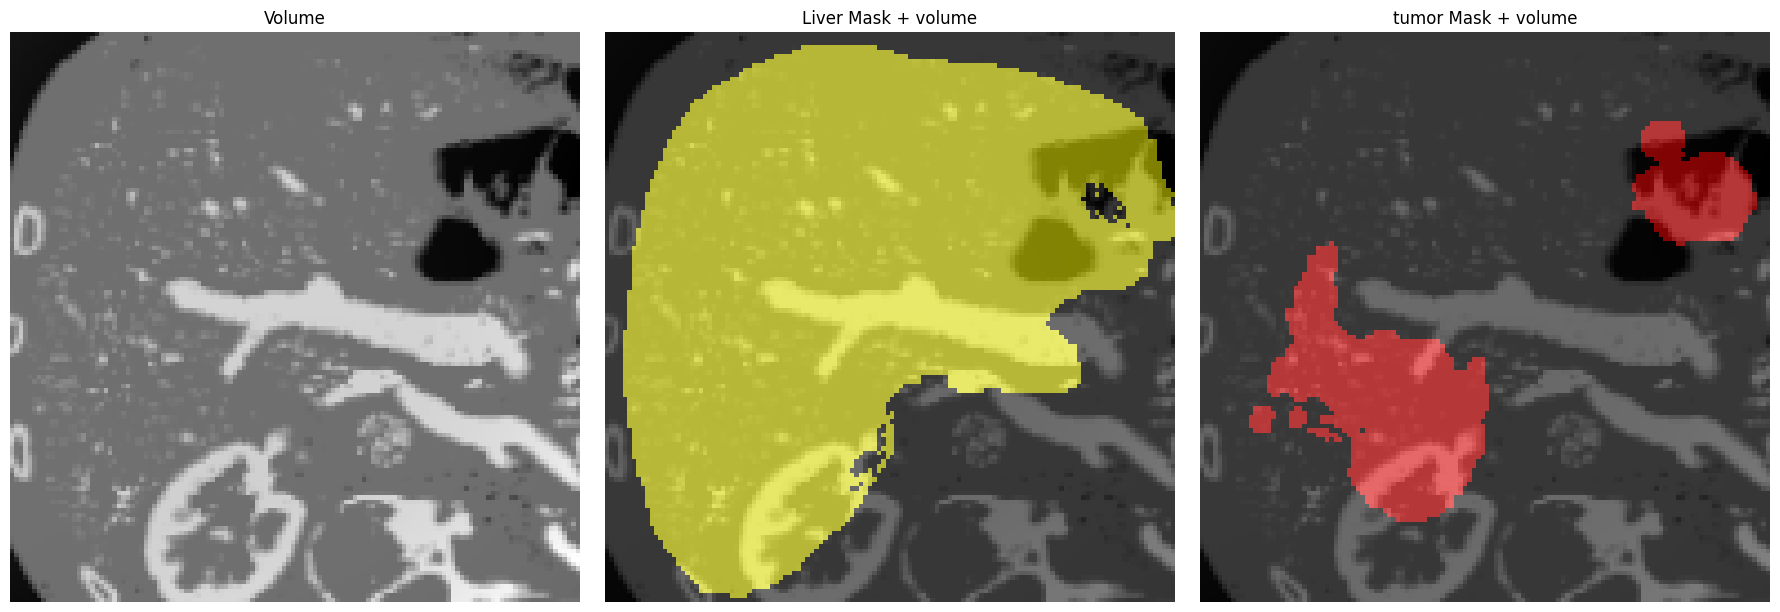

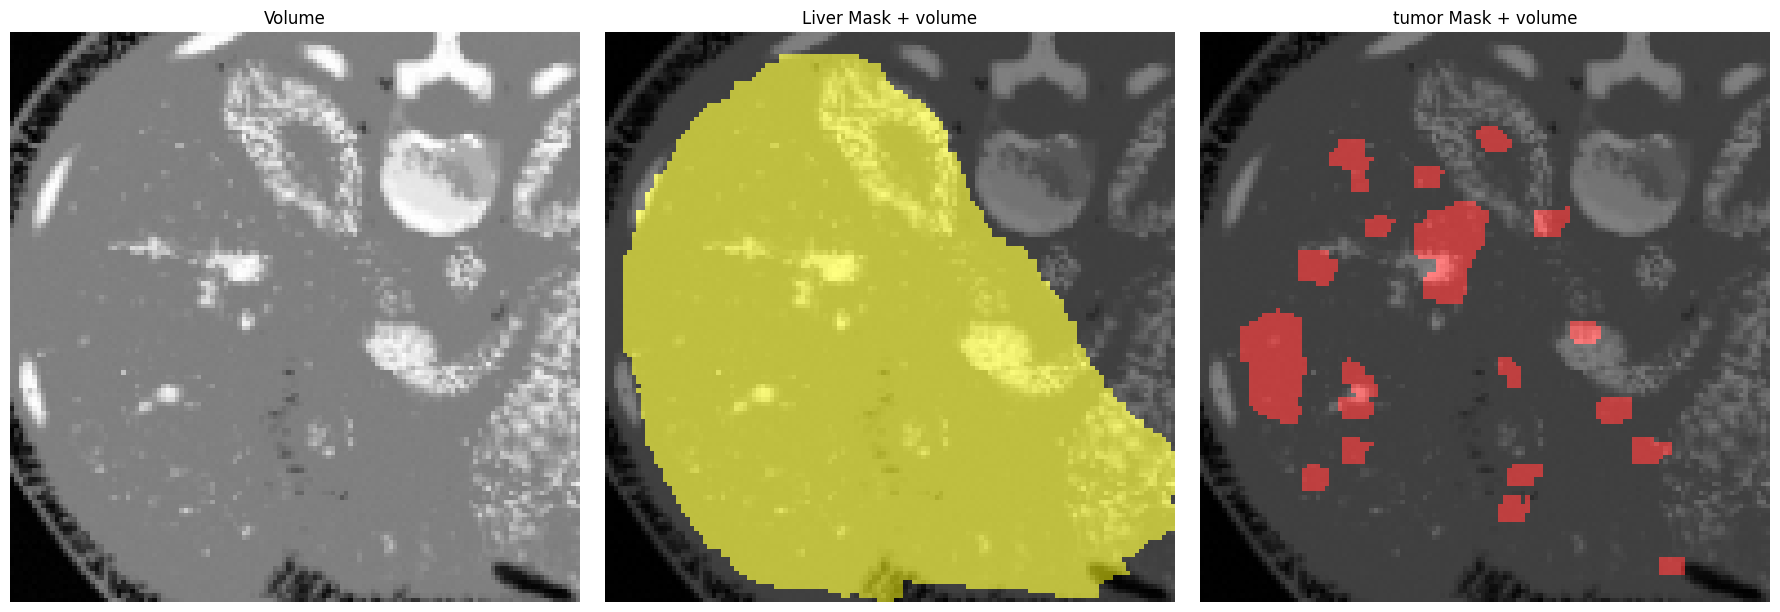

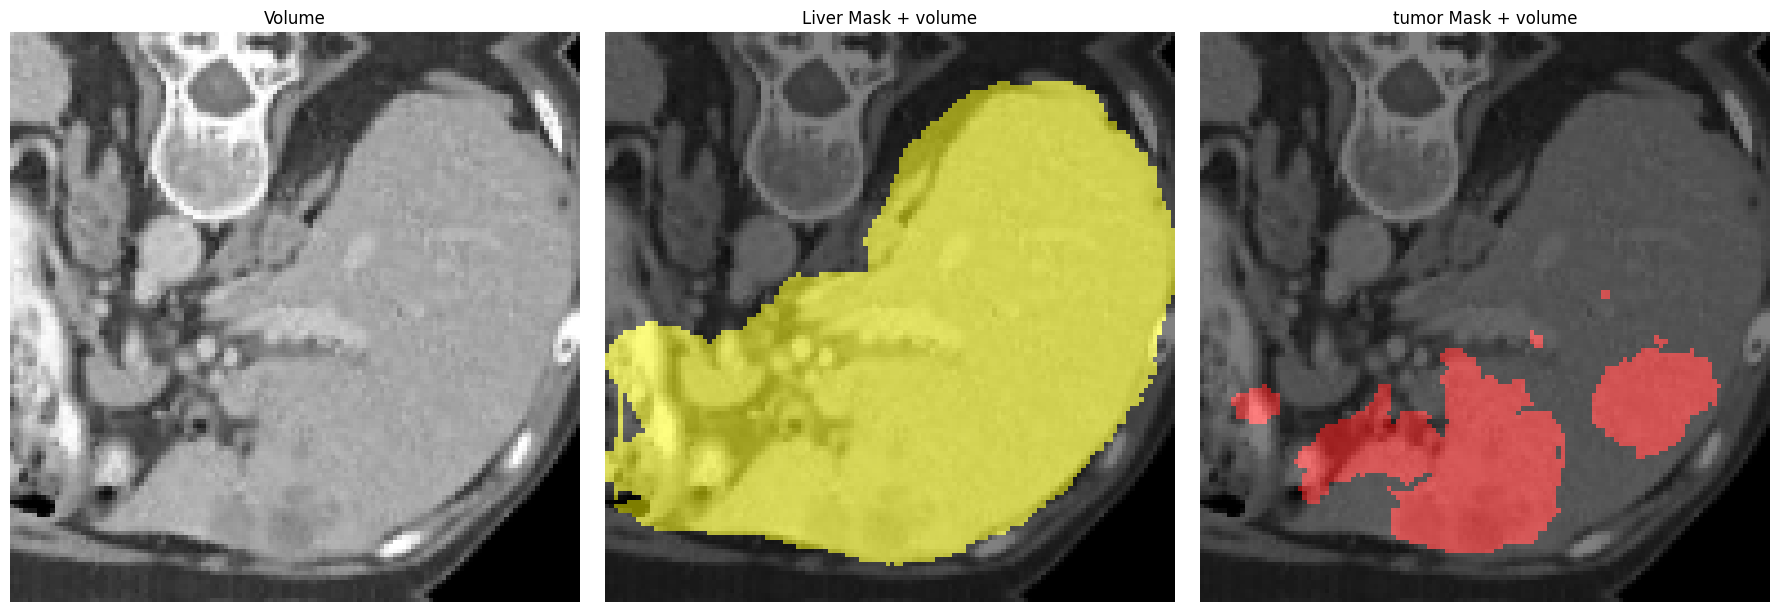

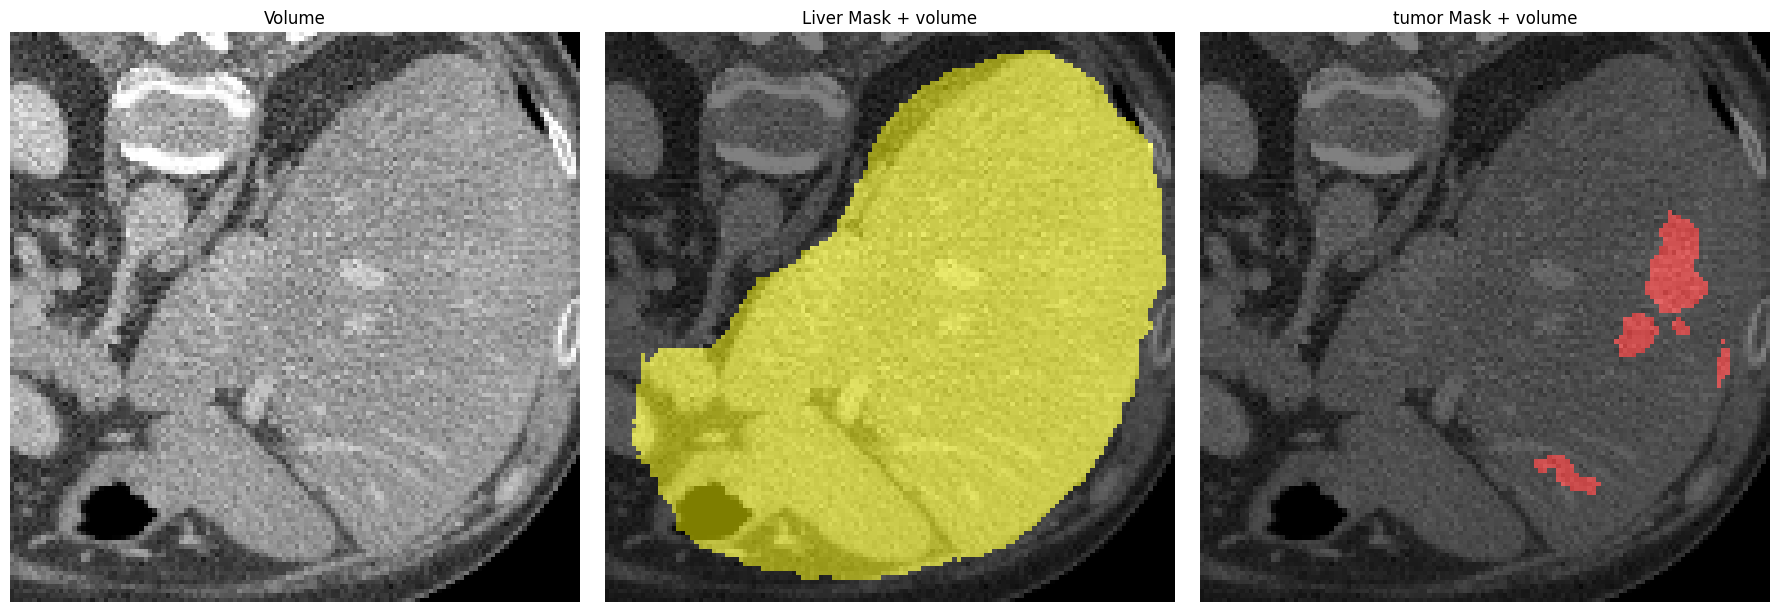

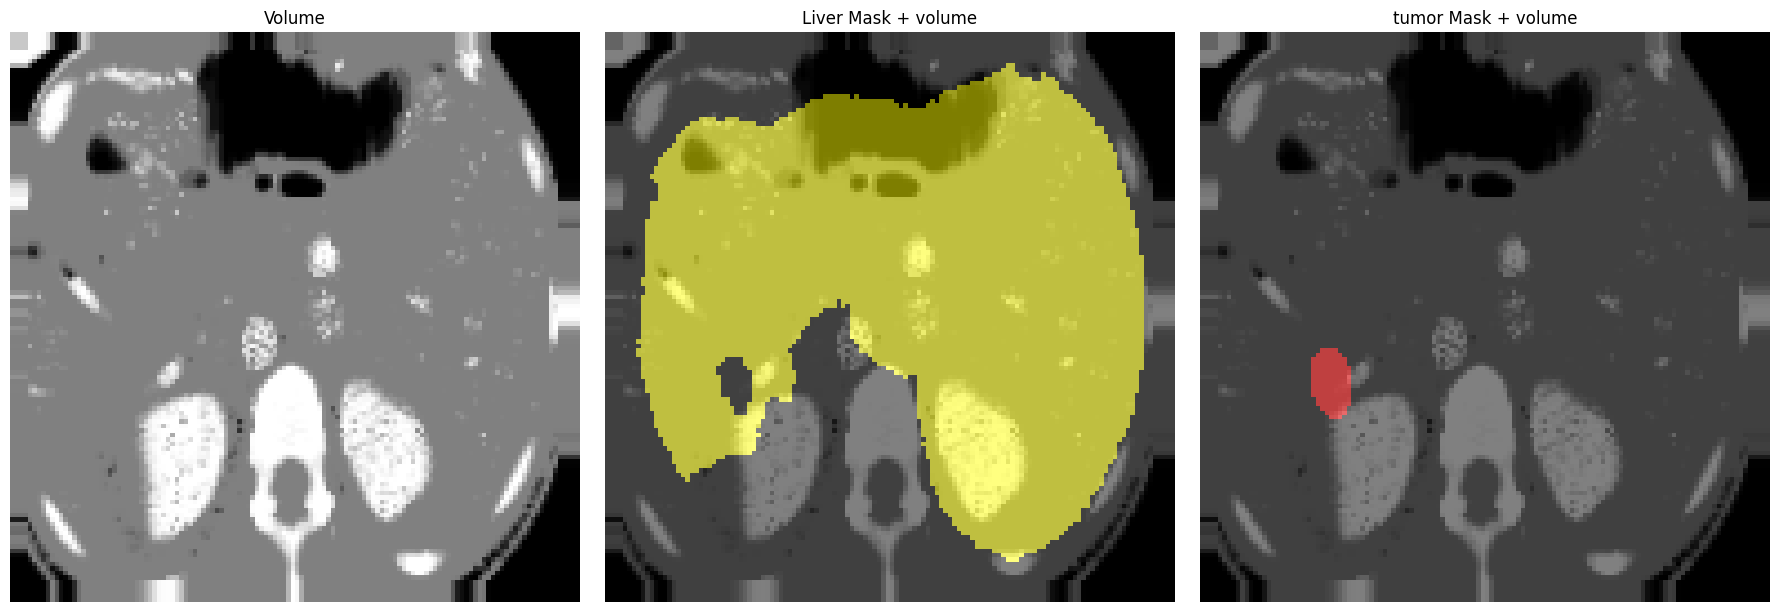

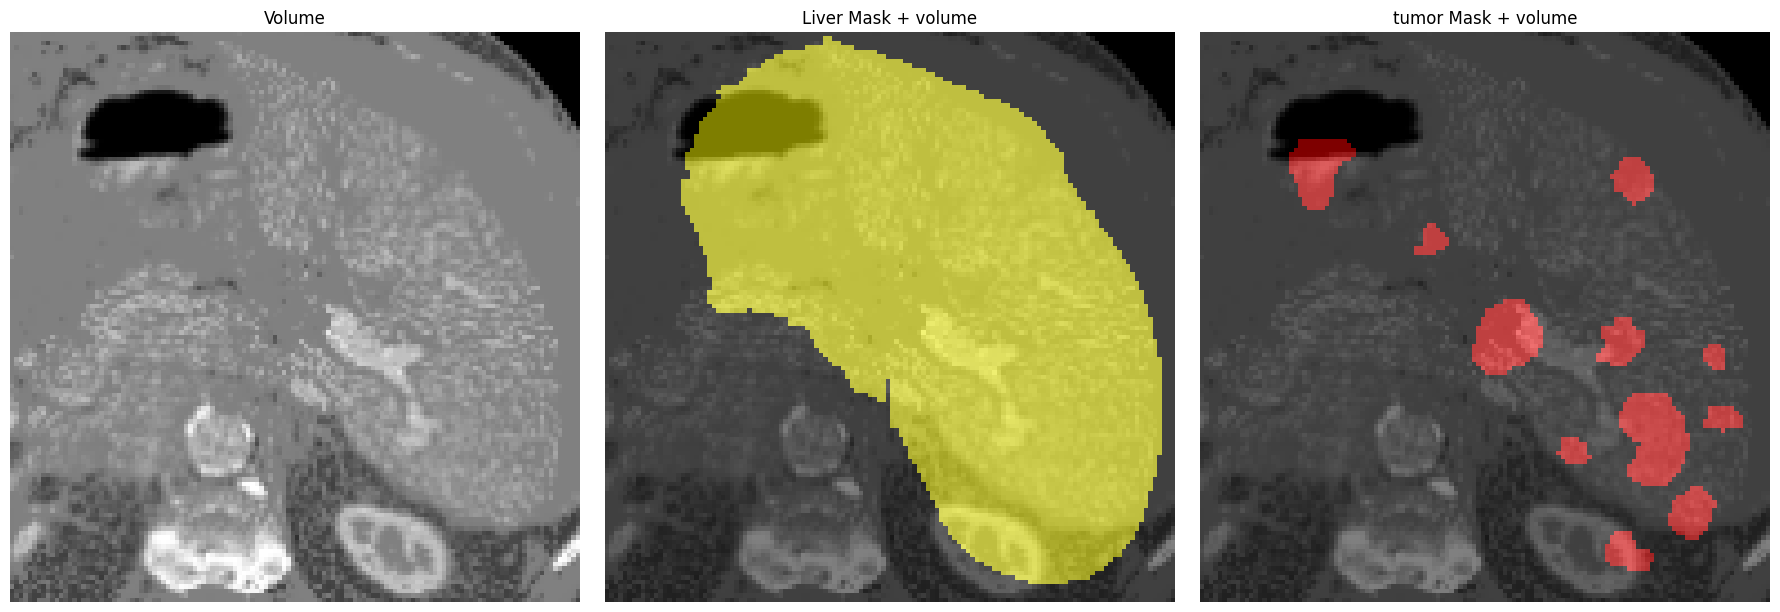

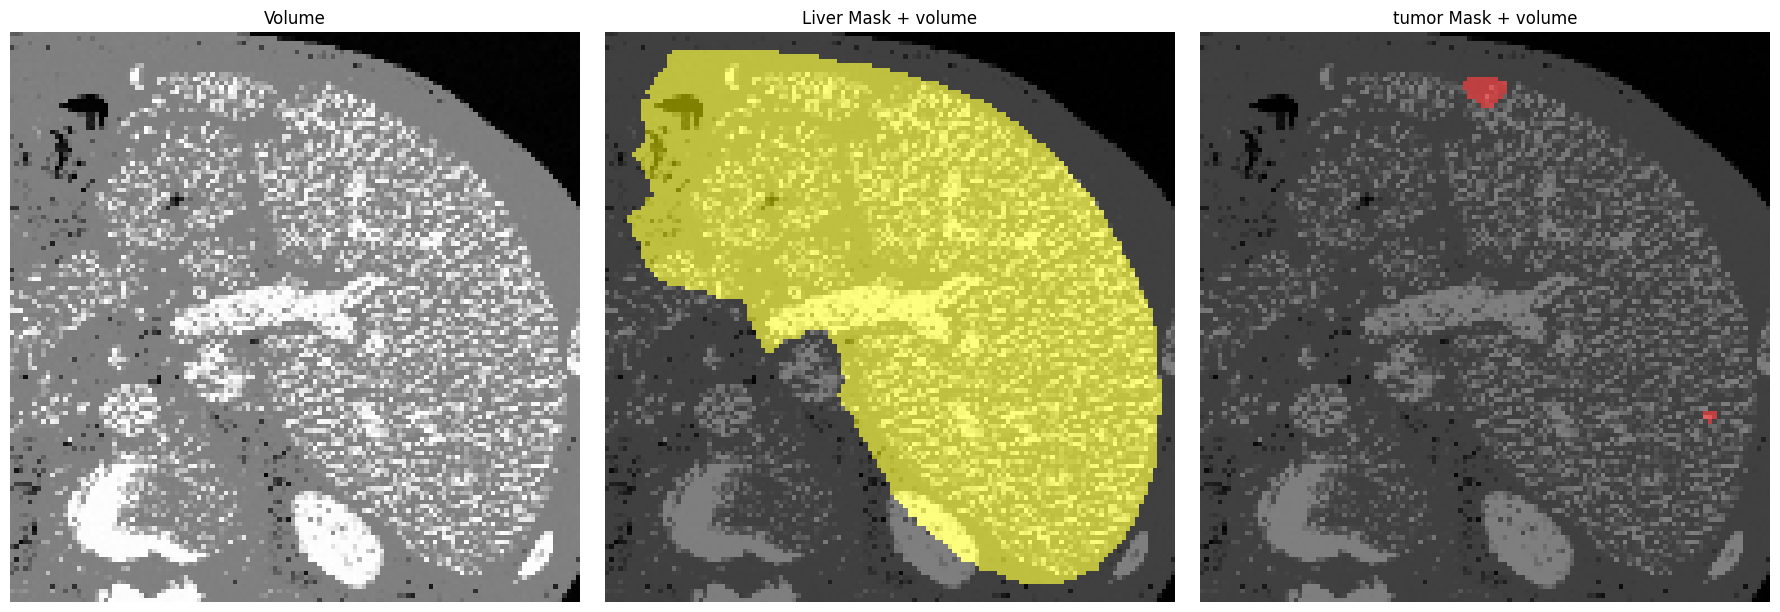

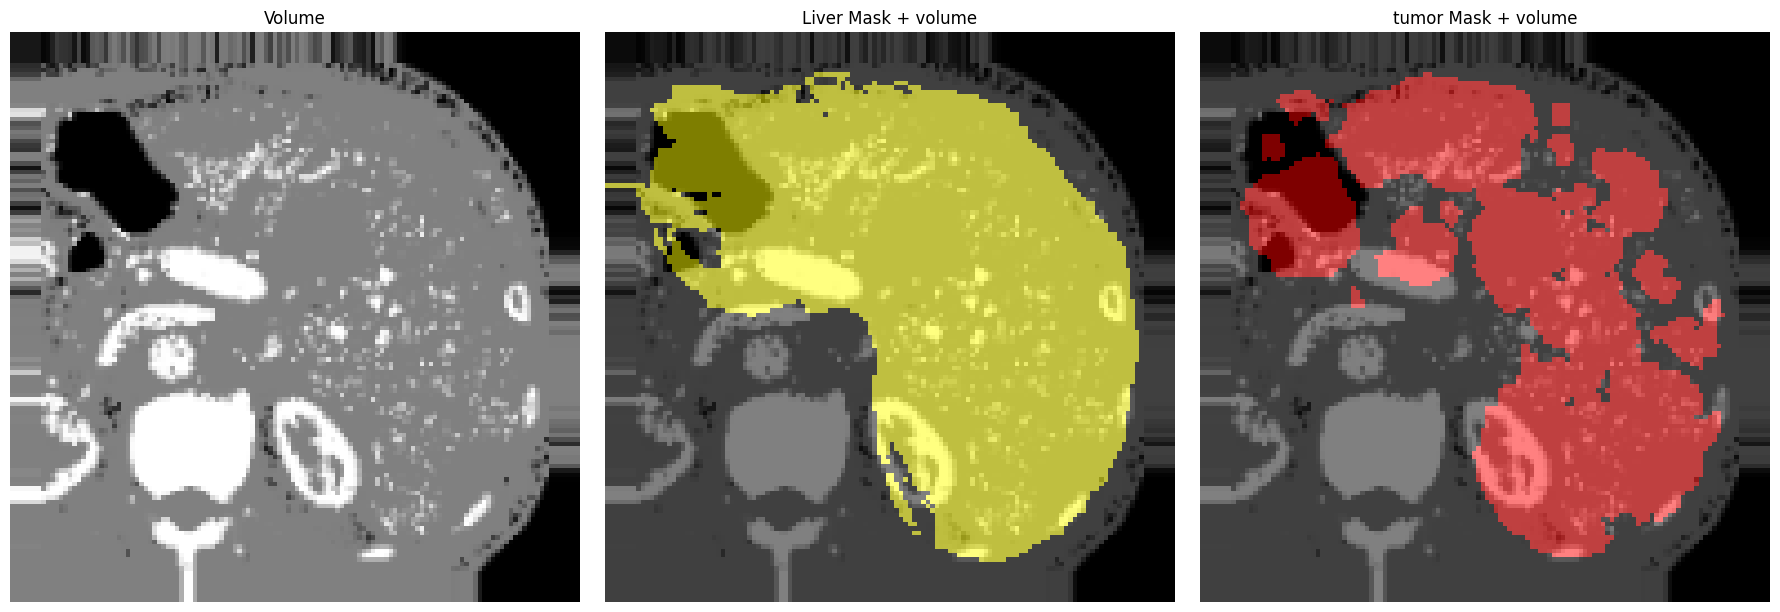

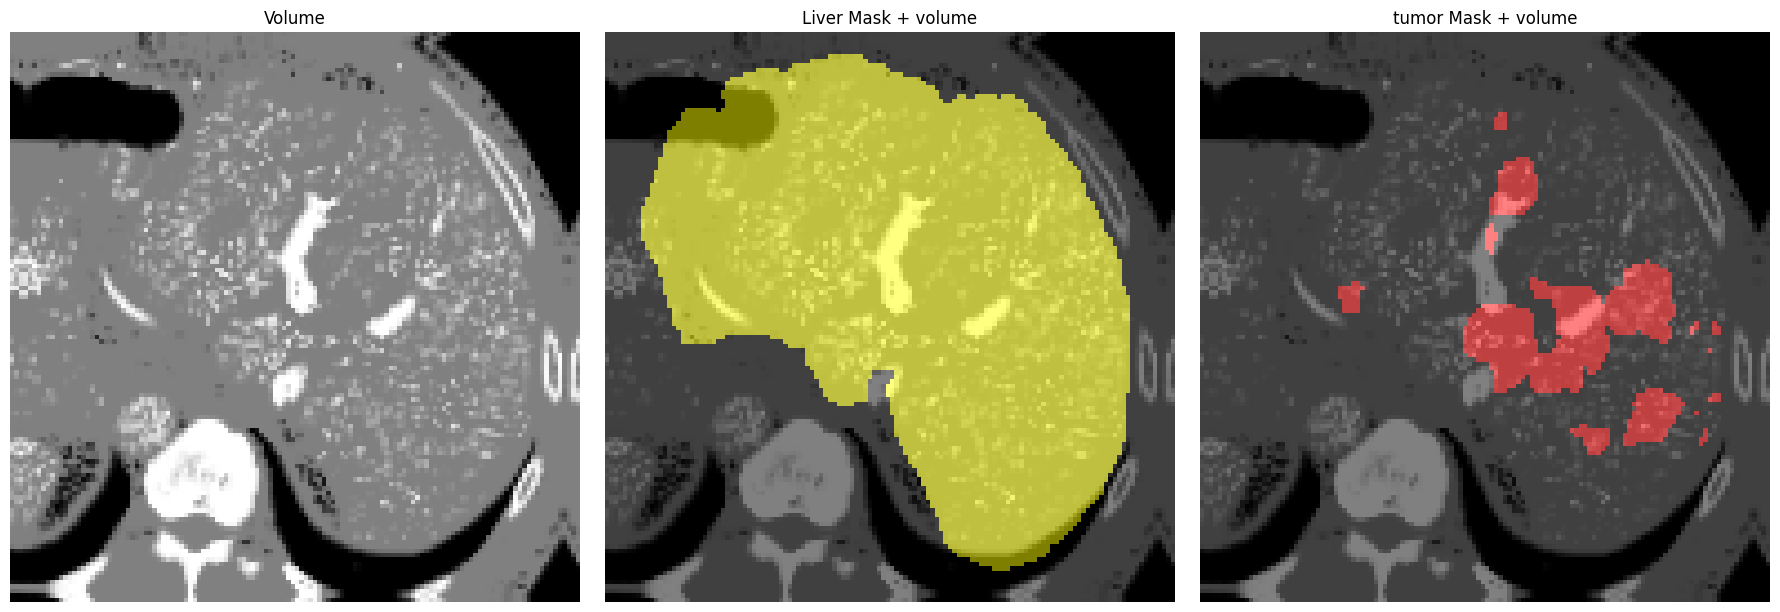

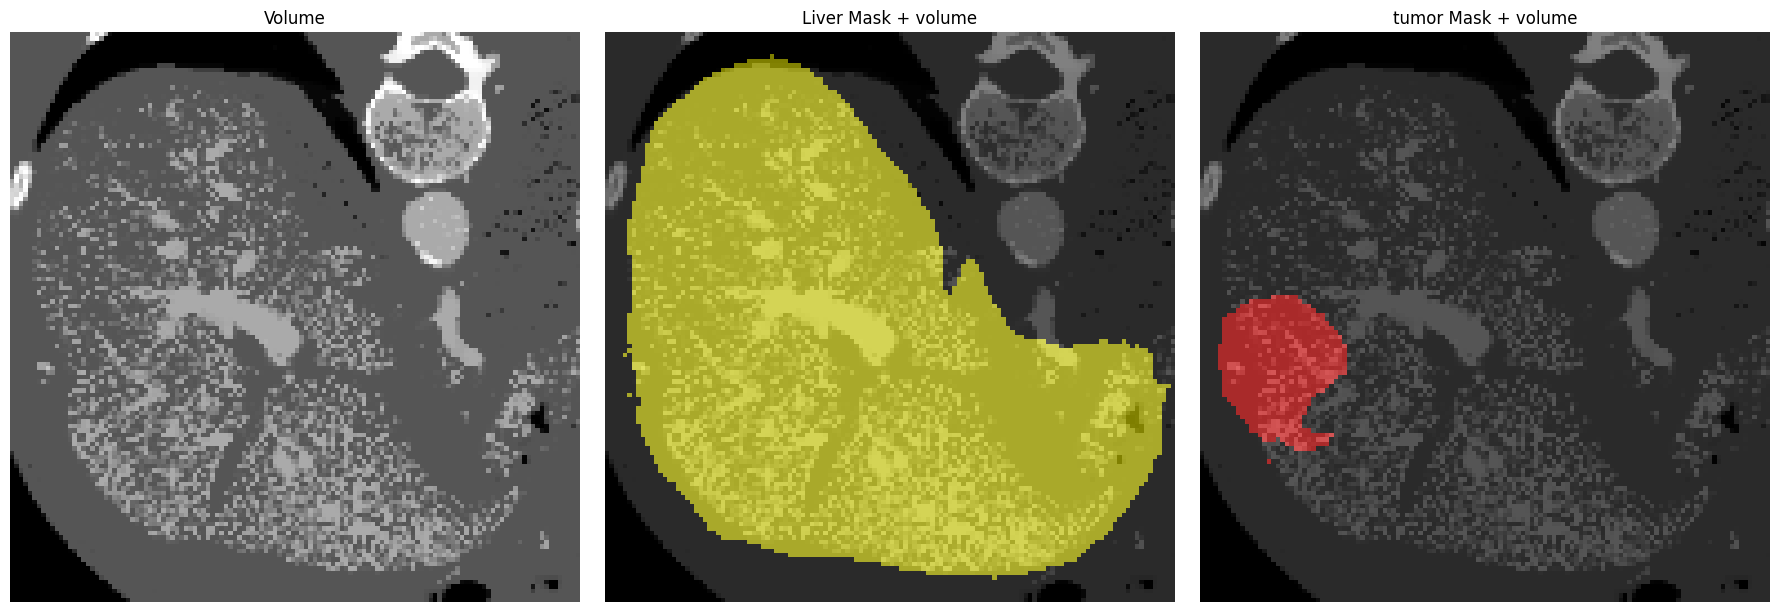

In [11]:
i = 0
for train_data in train_loader:
    i+= 1
    image = train_data["image"]
    label = train_data["label"]
    liver_mask = train_data["liver_mask"]
    visualize_from_loader(image, label, liver_mask)
    # print(image.shape, label.shape, liver_mask.shape)
    if i == 10:
      break


In [11]:
i = 0
for val_data in val_loader:
    i+= 1
    image = val_data["image"]
    label = val_data["label"]
    liver_mask = val_data["liver_mask"]
    bbox = val_data["bbox"]
    # visualize_from_loader(image, label, liver_mask)
    print(image.shape, label.shape, liver_mask.shape, )
    if i == 5:
      break

torch.Size([1, 1, 93, 232, 308]) torch.Size([1, 1, 93, 232, 308]) torch.Size([1, 1, 93, 232, 308])
torch.Size([1, 1, 0, 236, 268]) torch.Size([1, 1, 0, 236, 268]) torch.Size([1, 1, 0, 236, 268])
torch.Size([1, 1, 93, 292, 296]) torch.Size([1, 1, 93, 292, 296]) torch.Size([1, 1, 93, 292, 296])
torch.Size([1, 1, 79, 252, 264]) torch.Size([1, 1, 79, 252, 264]) torch.Size([1, 1, 79, 252, 264])
torch.Size([1, 1, 191, 304, 288]) torch.Size([1, 1, 191, 304, 288]) torch.Size([1, 1, 191, 304, 288])


## Training

In [10]:
criterion = TverskyLossWSigmoid(use_fc=True).to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [11]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_tumor,
    loss_epochs,
    trains_epoch,
    ious_tumor,
    precisions_tumor,
    recalls_tumor,
    time_tmp
) = trainer_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    # max_epochs = config["max_epochs"],
    max_epochs = 20,
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=False,
    post_fix="tumor"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/20 1/105 loss: 0.7034 time 11.94s
Epoch 1/20 2/105 loss: 0.7049 time 3.50s
Epoch 1/20 3/105 loss: 0.7050 time 15.13s
Epoch 1/20 4/105 loss: 0.7049 time 3.09s
Epoch 1/20 5/105 loss: 0.7015 time 2.32s
Epoch 1/20 6/105 loss: 0.7018 time 12.05s
Epoch 1/20 7/105 loss: 0.6984 time 4.14s
Epoch 1/20 8/105 loss: 0.6989 time 2.86s
Epoch 1/20 9/105 loss: 0.6992 time 7.23s
Epoch 1/20 10/105 loss: 0.6994 time 9.88s
Epoch 1/20 11/105 loss: 0.6995 time 14.89s
Epoch 1/20 12/105 loss: 0.6951 time 9.09s
Epoch 1/20 13/105 loss: 0.6956 time 3.84s
Epoch 1/20 14/105 loss: 0.6954 time 15.08s
Epoch 1/20 15/105 loss: 0.6956 time 14.36s
Epoch 1/20 16/105 loss: 0.6960 time 4.32s
Epoch 1/20 17/105 loss: 0.6917 time 16.48s
Epoch 1/20 18/105 loss: 0.6919 time 9.47s
Epoch 1/20 19/105 loss: 0.6924 time 2.63s
Epoch 1/20 20/105 loss: 0.6929 time 15.82s
Epoch 1/20 21/105 loss: 0.6932 time 2.96s
Epoch 1/20 22/105 loss: 0.6907 time 6.53s
Epoch 1/20 23/105 loss: 0.6902 time 12.65s
Epoch 1/20 24/105 loss: 0.6903 tim

Final training epochs: 1/20 ---[loss: 0.6877] ---[time 819.08s]
INFO:kltn.utils.logger:Final training epochs: 1/20 ---[loss: 0.6877] ---[time 819.08s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/20 105/105 loss: 0.6877 time 3.90s


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mask in method wrapper_CUDA__masked_select)

In [ ]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_tumor.json"

results = {
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Víualize result

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

In [ ]:
num_images = len(val_loader)
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
visualize_results_stage_2(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [ ]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [ ]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/result_model_*.json"))

['/content/drive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json']


In [ ]:
model_result = load_metrics("/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json")

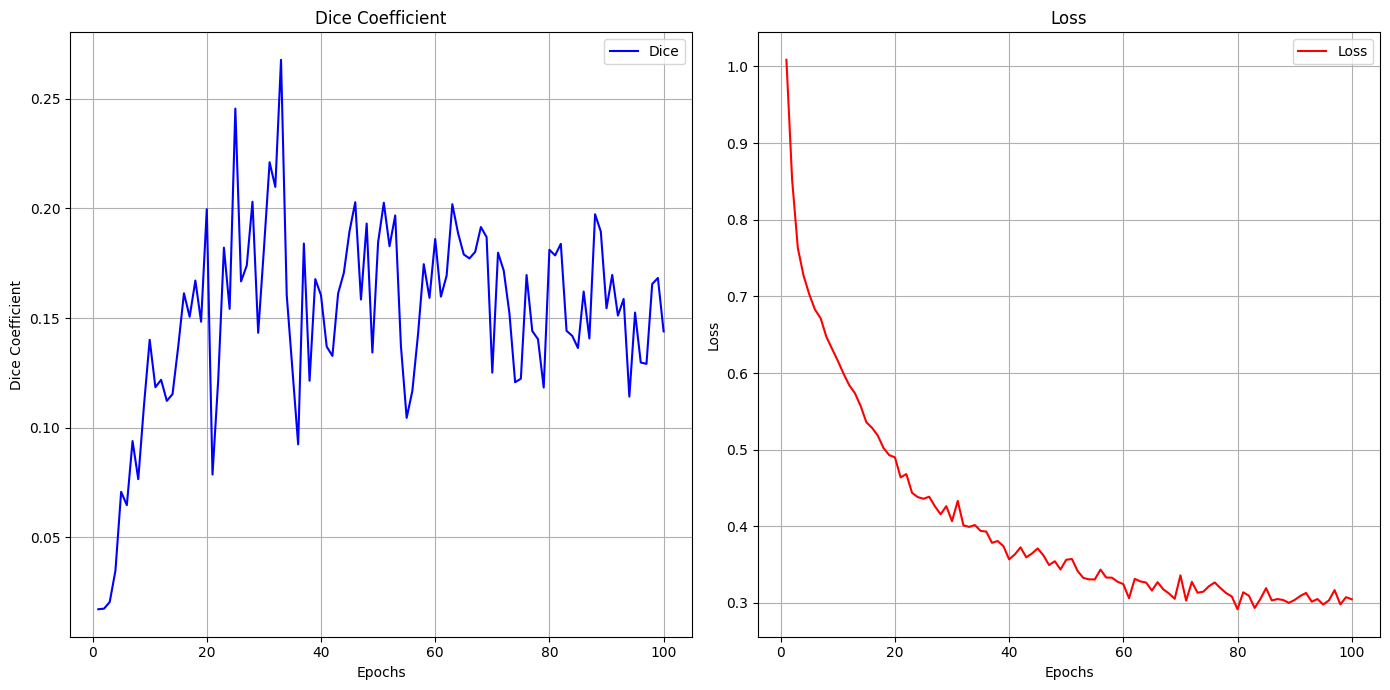

In [ ]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()